# Wizualizacja danych

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('cleaned_data.csv.gz', low_memory=False)
print(df.columns)

Index(['collison_id', 'latitude', 'longitude', 'num_pedestrians_killed',
       'date', 'num_motorist_killed', 'num_persons_killed',
       'vehicle_type_name', 'vehicle_type', 'num_pedestrians_injured',
       'location', 'time', 'num_persons_injured', 'num_motorist_injured',
       'borough', 'zip_code', 'num_cyclist_injured', 'num_cyclist_killed',
       'contributing_factor_type', 'contributing_factor_name', 'street_name'],
      dtype='object')


## Określenie najniebezpieczniejszych czynników wypadków w każdej z dzielnic NY

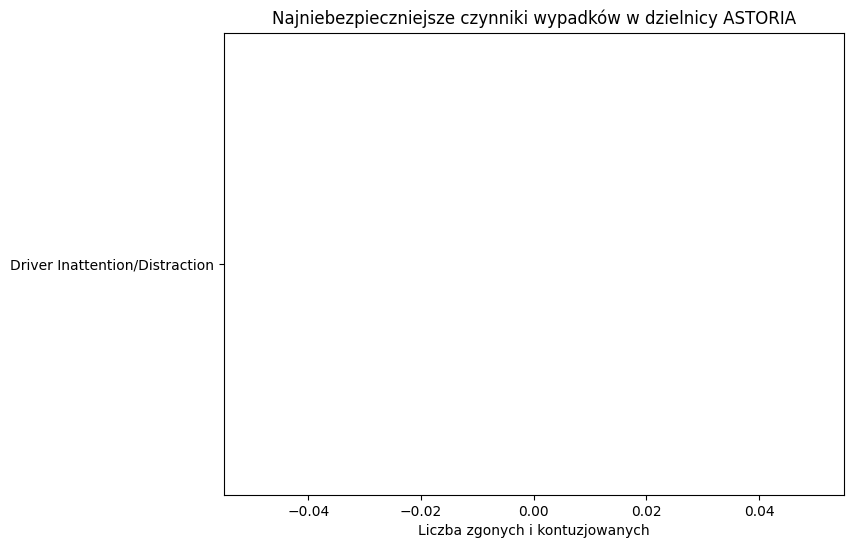

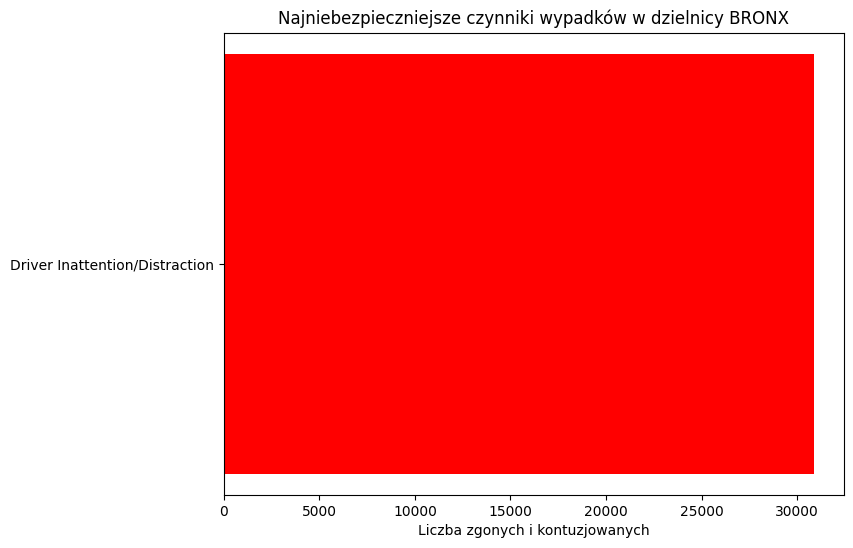

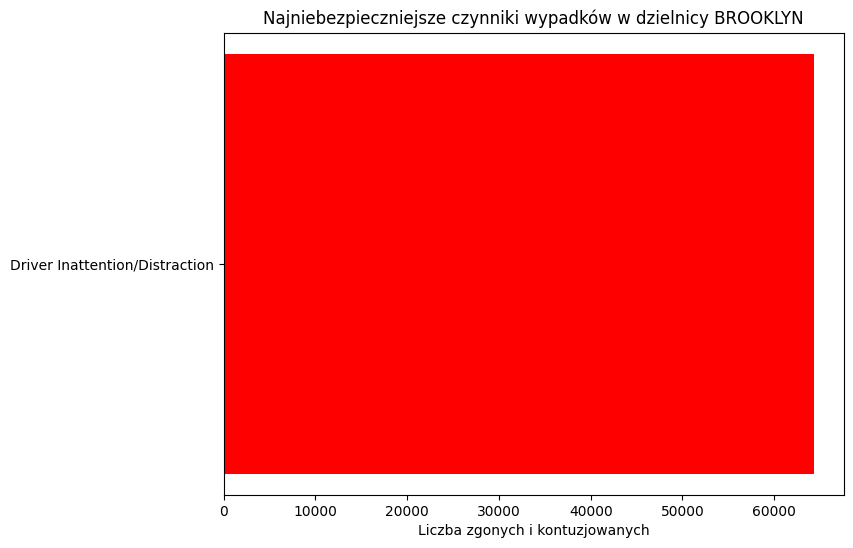

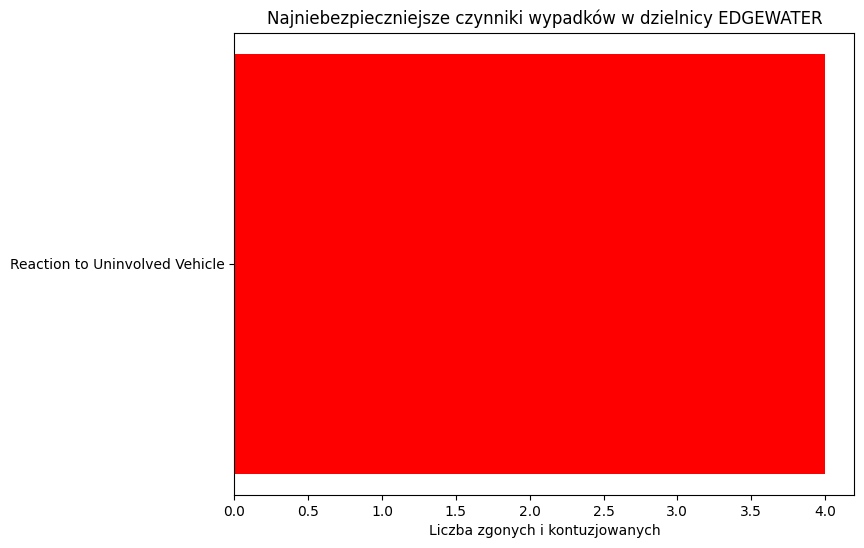

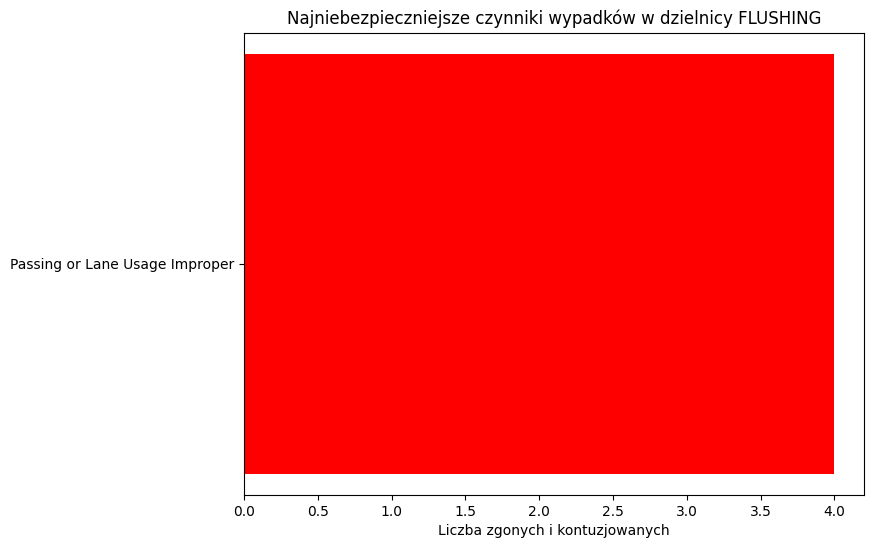

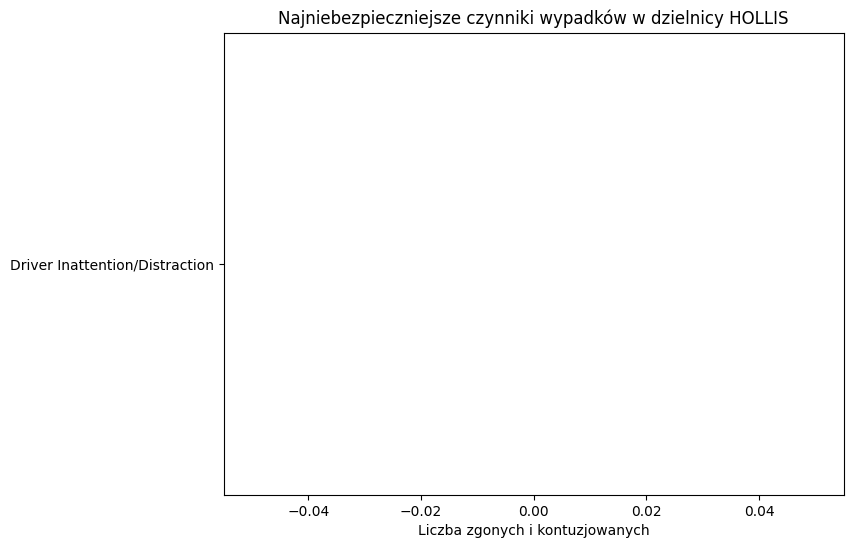

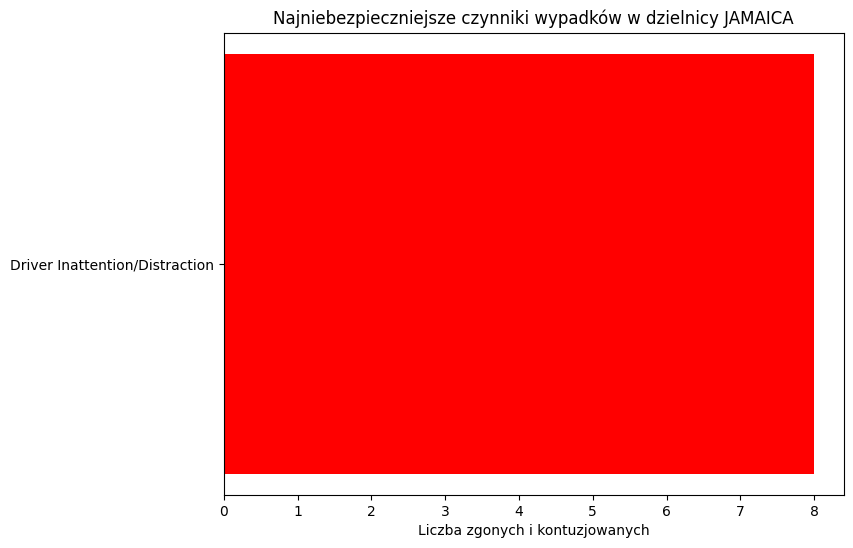

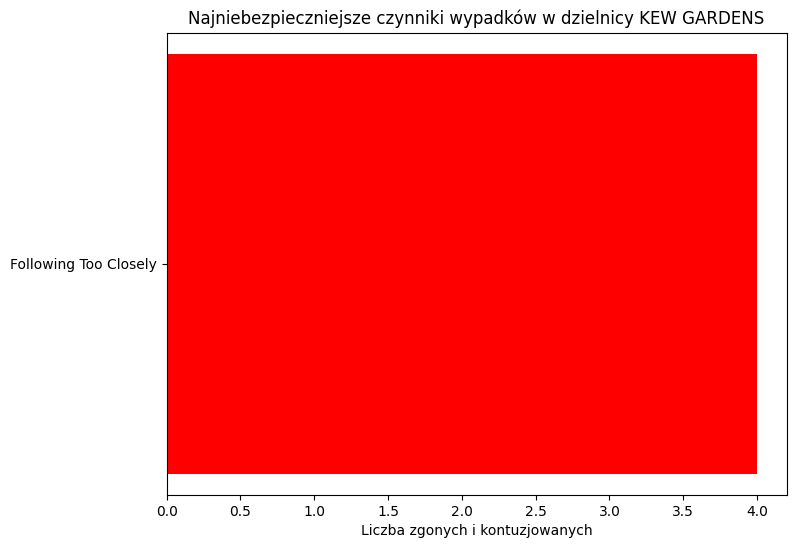

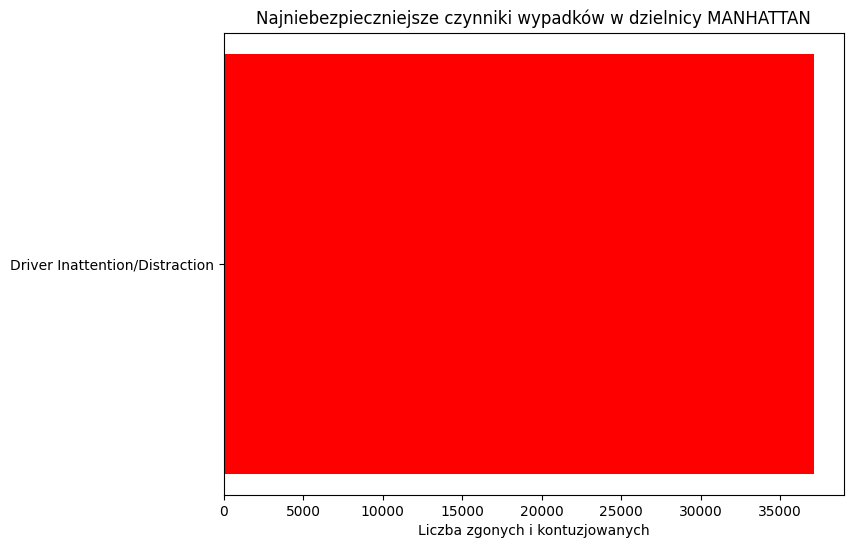

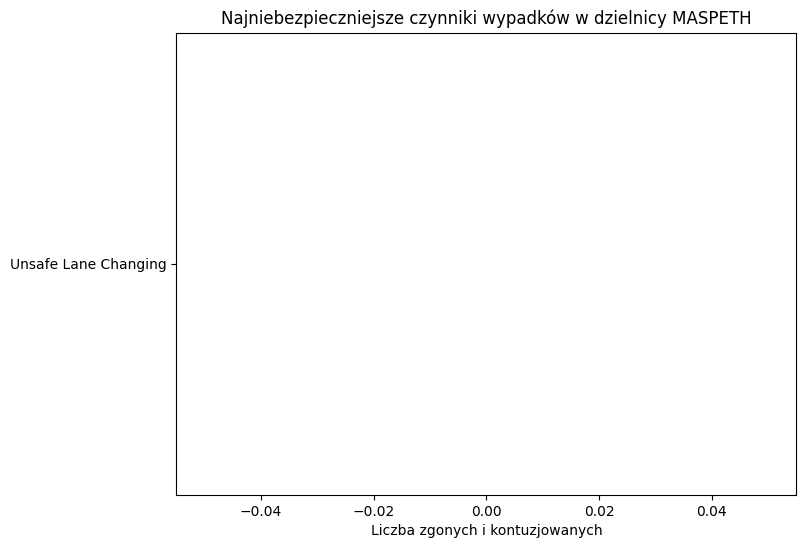

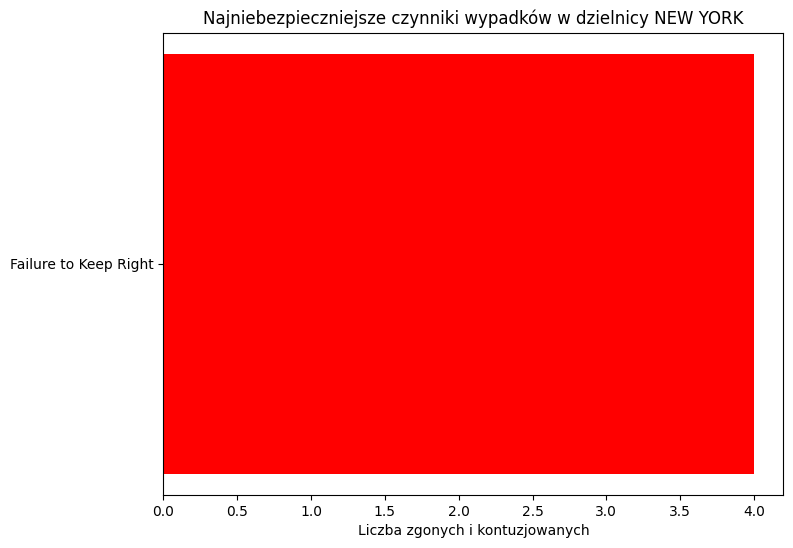

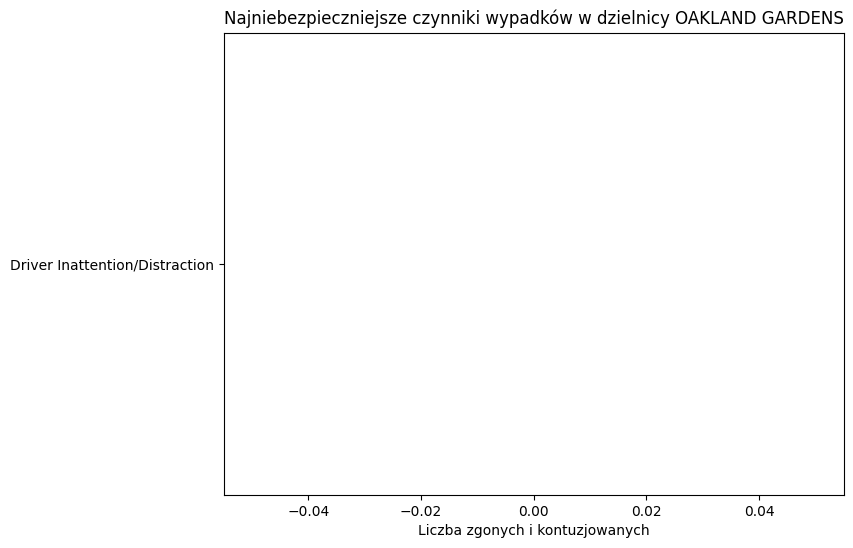

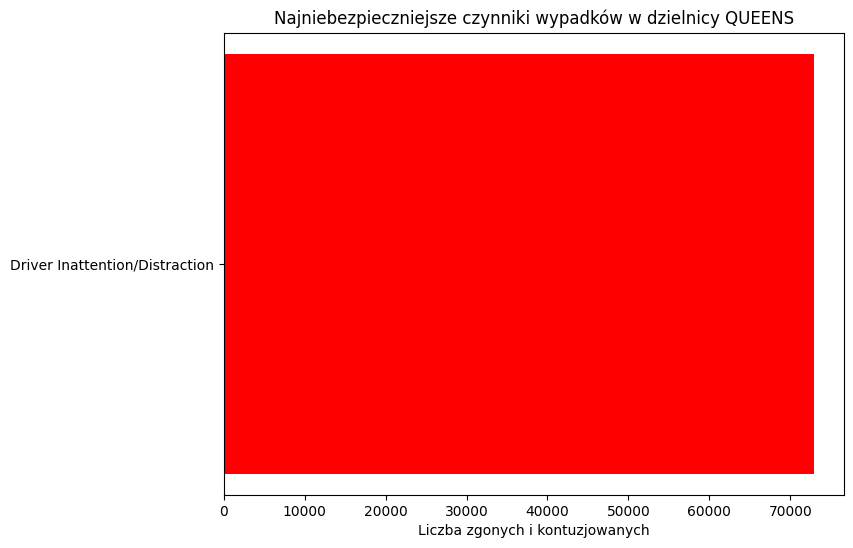

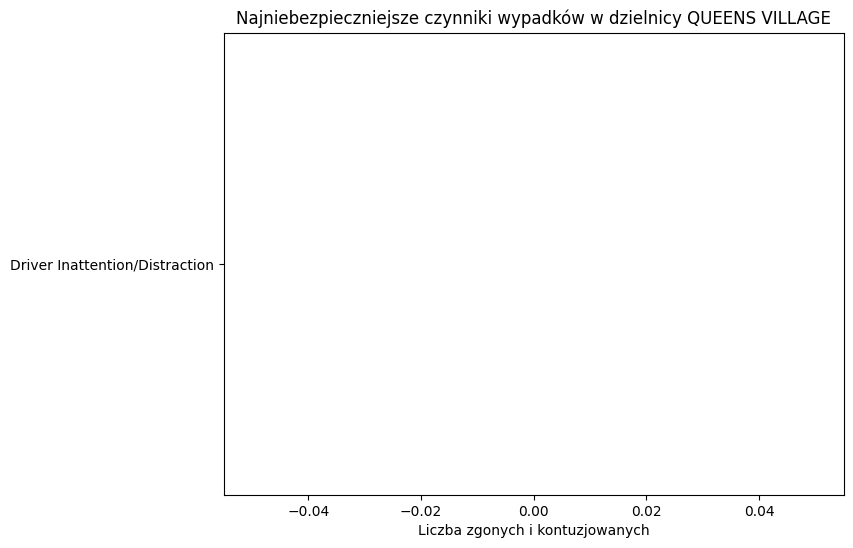

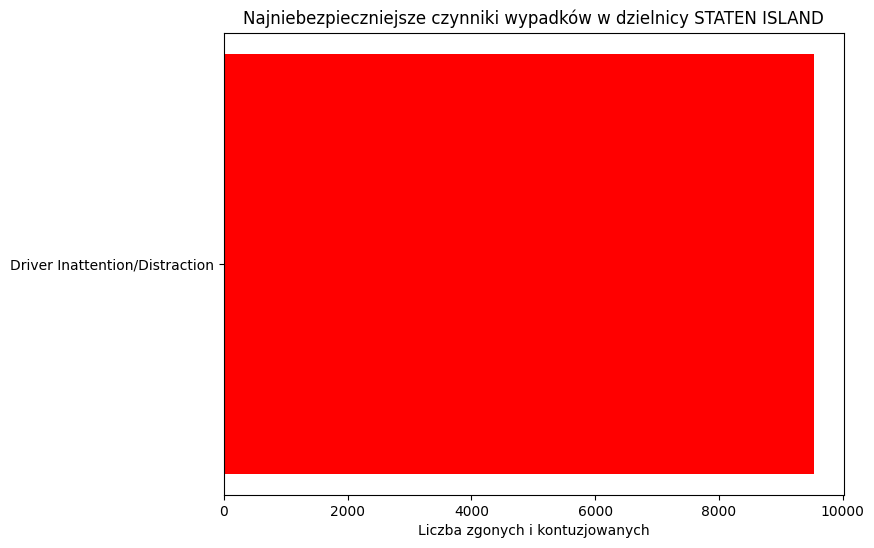

In [28]:
# Wybierz tylko odpowiednie kolumny
selected_columns = ['borough', 'contributing_factor_name', 
                    'num_pedestrians_killed', 'num_motorist_killed', 'num_persons_killed',
                    'num_pedestrians_injured', 'num_persons_injured', 'num_motorist_injured',
                    'num_cyclist_injured', 'num_cyclist_killed']

# Wybierz wiersze bez czynnika 'Unspecified'
df = df[df['contributing_factor_name'] != 'Unspecified']

# Grupuj dane według dzielnic i czynników wypadków, sumując zgony i kontuzje
grouped = df.groupby(['borough', 'contributing_factor_name'])[selected_columns[2:]].sum().reset_index()

# Oblicz łączną liczbę zgonów i kontuzji
grouped['total_casualties'] = grouped[['num_pedestrians_killed', 'num_motorist_killed', 'num_persons_killed',
                                      'num_pedestrians_injured', 'num_persons_injured', 'num_motorist_injured',
                                      'num_cyclist_injured', 'num_cyclist_killed']].sum(axis=1)

# Wybierz najniebezpieczniejsze czynniki wypadków dla każdej dzielnicy
most_dangerous_factors = grouped.loc[grouped.groupby('borough')['total_casualties'].idxmax()]

# Stwórz wykresy przedstawiające najniebezpieczniejsze czynniki wypadków
for borough in most_dangerous_factors['borough'].unique():
    data = most_dangerous_factors[most_dangerous_factors['borough'] == borough]
    plt.figure(figsize=(8, 6))
    plt.barh(data['contributing_factor_name'], data['total_casualties'], color='red')
    plt.xlabel('Liczba zgonych i kontuzjowanych')
    plt.title(f'Najniebezpieczniejsze czynniki wypadków w dzielnicy {borough}')
    plt.show()

## Zaprezentowanie, ile zgonów oraz obrażeń zostało spowodowanych przez szybką jazdę w danej dzielnicy

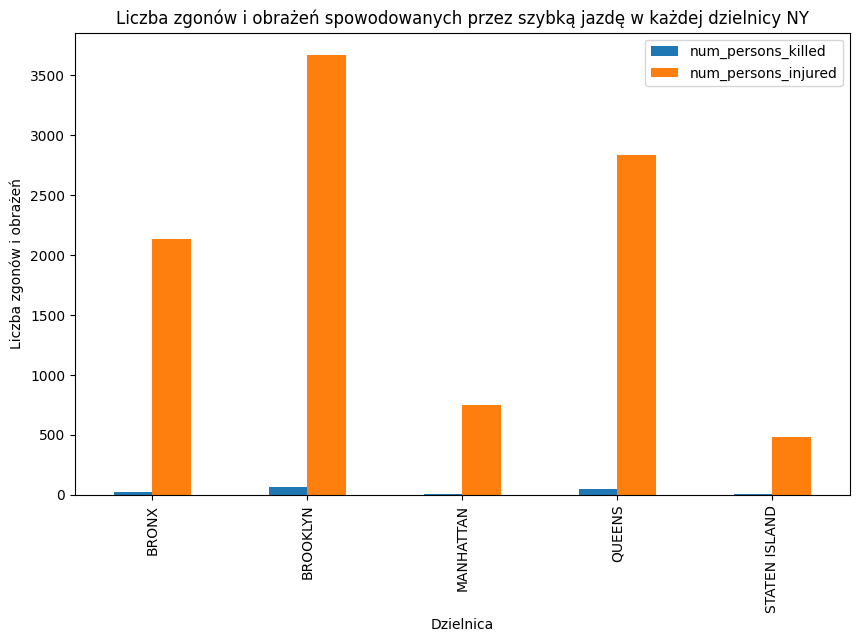

In [15]:
speeding_df = df[df['contributing_factor_name'] == 'Unsafe Speed']

#Sumujemy liczbę zgonów i obrażeń dla każdej dzielnicy
borough_stats = speeding_df.groupby('borough').agg({
    'num_persons_killed': 'sum',
    'num_persons_injured': 'sum'
}).reset_index()

#Tworzenie wykresu
borough_stats.plot(x='borough', y=['num_persons_killed', 'num_persons_injured'], kind='bar', figsize=(10,6))
plt.xlabel('Dzielnica')
plt.ylabel('Liczba zgonów i obrażeń')
plt.title('Liczba zgonów i obrażeń spowodowanych przez szybką jazdę w każdej dzielnicy NY')
plt.show()

## Określenie 3 najczęstszych czynników wypadków z podziałem na dzielnice oraz ogółem dla całego miasta

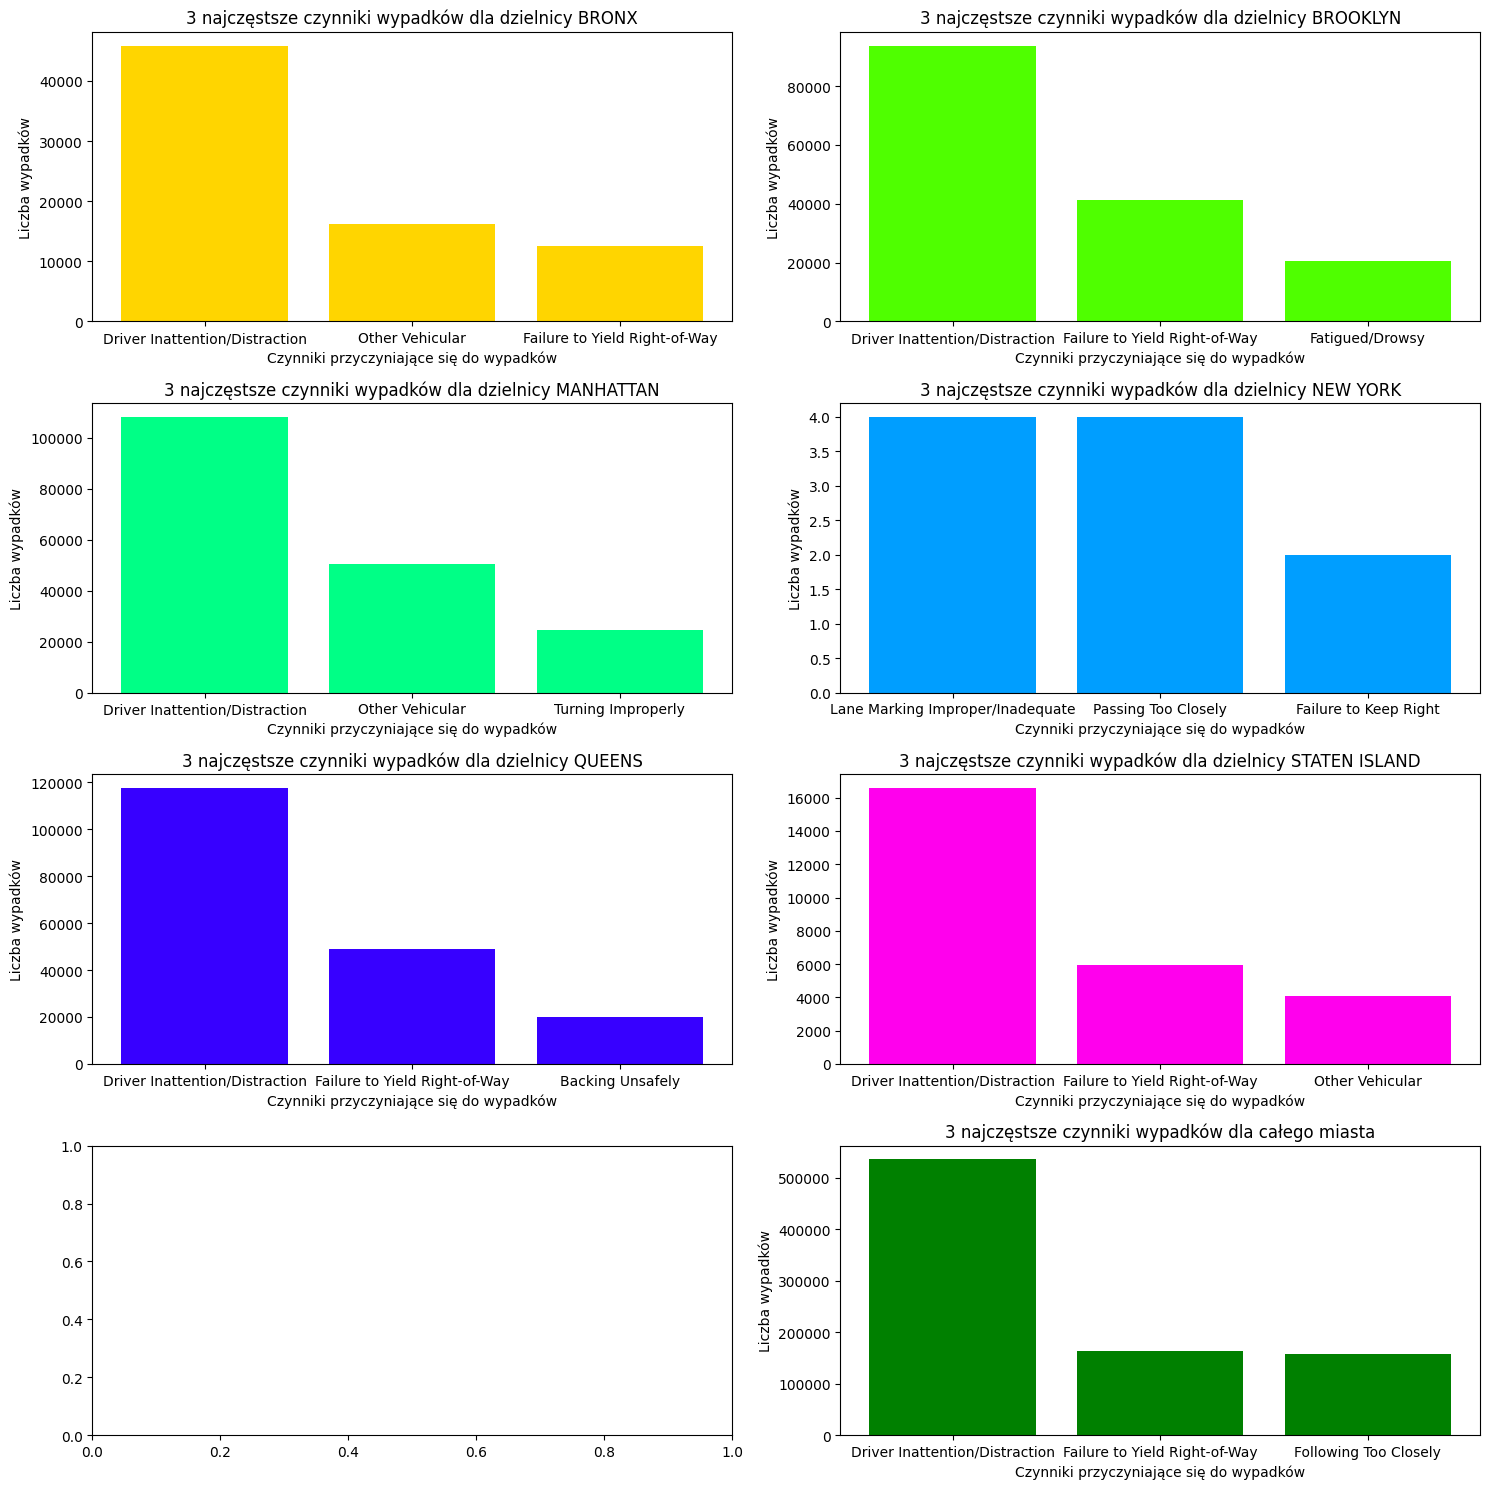

In [31]:
import seaborn as sns

# Usuwanie wierszy z 'Unspecified' w kolumnie 'contributing_factor_name'
df = df[df['contributing_factor_name'] != 'Unspecified']

# Zliczanie wystąpień czynników przyczyniających się do wypadków dla każdej dzielnicy
borough_factors = df.groupby(['borough', 'contributing_factor_name']).size().reset_index(name='counts')

# Wyznaczanie 3 najczęstszych czynników dla każdej dzielnicy
top_borough_factors = borough_factors.groupby('borough').apply(lambda x: x.nlargest(3, 'counts')).reset_index(drop=True)

# Filtracja dzielnic, gdzie były przynajmniej 3 różne czynniki wypadków
top_borough_factors_filtered = top_borough_factors[top_borough_factors['borough'].isin(top_borough_factors['borough'].value_counts()[top_borough_factors['borough'].value_counts() >= 3].index)]

# Zliczanie wystąpień czynników przyczyniających się do wypadków dla całego miasta
city_factors = df['contributing_factor_name'].value_counts().reset_index()
city_factors.columns = ['contributing_factor_name', 'counts']

# Wyznaczanie 3 najczęstszych czynników dla całego miasta
top_city_factors = city_factors.nlargest(3, 'counts')

# Wyświetlanie wyników w formie wykresów słupkowych
boroughs = top_borough_factors_filtered['borough'].unique()
num_boroughs = len(boroughs)
fig, axs = plt.subplots(num_boroughs//2+1, 2, figsize=(15, 5*num_boroughs//2))

colors = sns.color_palette('hsv', num_boroughs)

# Wykresy dla każdej dzielnicy
for i, borough in enumerate(boroughs):
    borough_data = top_borough_factors_filtered[top_borough_factors_filtered['borough'] == borough]
    axs[i//2, i%2].bar(borough_data['contributing_factor_name'], borough_data['counts'], color=colors[i])
    axs[i//2, i%2].set_title(f'3 najczęstsze czynniki wypadków dla dzielnicy {borough}')
    axs[i//2, i%2].set_xlabel('Czynniki przyczyniające się do wypadków')
    axs[i//2, i%2].set_ylabel('Liczba wypadków')

# Wykres dla całego miasta
axs[-1, -1].bar(top_city_factors['contributing_factor_name'], top_city_factors['counts'], color='green')
axs[-1, -1].set_title('3 najczęstsze czynniki wypadków dla całego miasta')
axs[-1, -1].set_xlabel('Czynniki przyczyniające się do wypadków')
axs[-1, -1].set_ylabel('Liczba wypadków')

plt.tight_layout()
plt.show()


## Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach

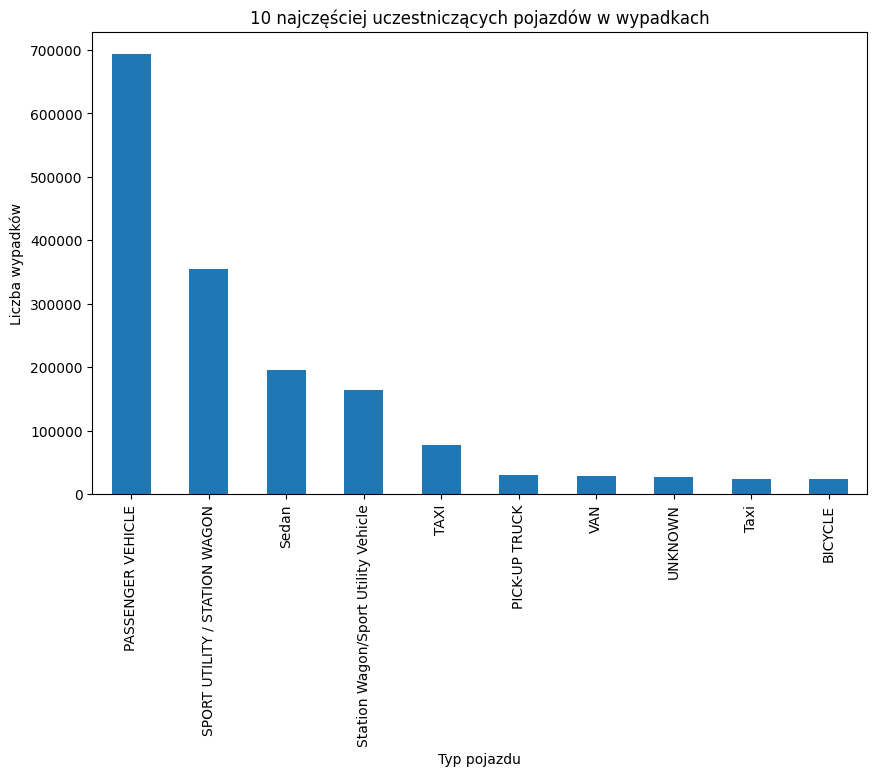

In [17]:
vehicle_counts = df['vehicle_type_name'].value_counts().head(10)

# Utwórz wykres
plt.figure(figsize=(10,6))
vehicle_counts.plot(kind='bar')
plt.title('10 najczęściej uczestniczących pojazdów w wypadkach')
plt.xlabel('Typ pojazdu')
plt.ylabel('Liczba wypadków')
plt.show()

## Statystyka ilości wypadków dla każdej z dzielnic

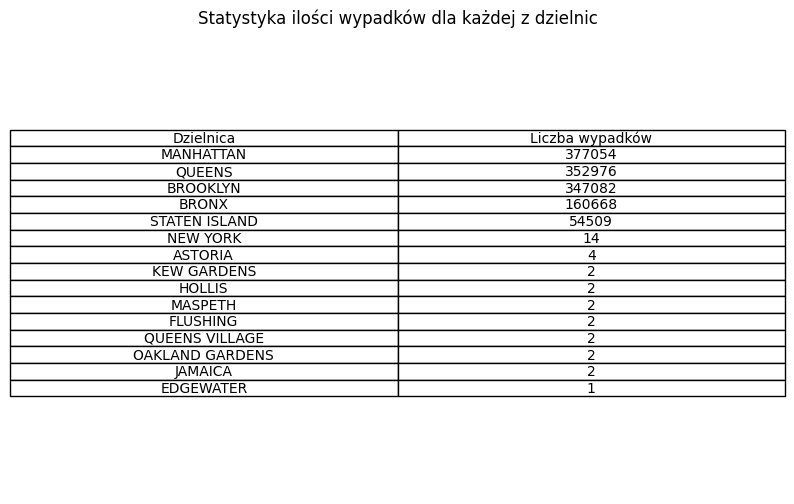

In [18]:
borough_counts = df['borough'].value_counts()

# Utwórz tabelę
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=borough_counts.reset_index().values,
         colLabels=['Dzielnica', 'Liczba wypadków'],
         cellLoc = 'center', loc='center')

plt.title('Statystyka ilości wypadków dla każdej z dzielnic')
plt.show()

## Najczęstsze miejsca wystąpienia wypadków

In [21]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap

df = pd.read_csv('cleaned_data.csv.gz')

#Sumowanie wszystkich kodów pocztowych 
zip_counts = df['zip_code'].value_counts().reset_index()
zip_counts.columns = ['zip_code', 'count']

#Załadowanie pliku GeoJSON z danymi geograficznymi dla kodów pocztowych
geo_data = gpd.read_file('new-york-zip-codes.geojson')

#Dołączenie danych o wypadkach do danych geograficznych
geo_data = geo_data.merge(zip_counts, left_on='ZCTA5CE10', right_on='zip_code', how='left')

geo_data['count'] = geo_data['count'].fillna(0)

#tworzenie mapy
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)  # Ustawiamy początkową lokalizację na Nowy Jork

#Przygotowanie danych do HeatMap
heat_data = [[row['geometry'].centroid.y, row['geometry'].centroid.x, row['count']] for index, row in geo_data.iterrows() if row['count'] > 0]

#Dodanie warstwy heatmap
HeatMap(heat_data).add_to(m)

#Wyświetlenie mapy
m


/tmp/ipykernel_11225/4250273366.py:6: DtypeWarning: Columns (4,7,8,10,11,14,15,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv.gz')
